In [1]:
from helpers import (
    preprocessing
)
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructField, StructType, IntegerType, DateType, FloatType, ArrayType, LongType, MapType
import warnings
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers
warnings.filterwarnings('ignore')

2022-08-08 20:24:14.028347: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# base de dados do twitter ja classificada com sentimentos
path = "/home/daholive/Documents/twitter_ellection_brazil_v2/datasource/raw_kaggle/TweetsWithTheme_v2.csv"

In [3]:
# instancia spark
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:1.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.executor.memory","4G") \
    .config("spark.driver.memory","4G") \
    .config("spark.executor.cores","12") \
    .config("spark.sql.execution.arrow.pyspark.enabled","true") \
    .getOrCreate()

22/08/08 20:24:18 WARN Utils: Your hostname, daholive-Dell-G15-5510 resolves to a loopback address: 127.0.1.1; using 192.168.0.114 instead (on interface wlp0s20f3)
22/08/08 20:24:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/daholive/.ivy2/cache
The jars for the packages stored in: /home/daholive/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2d97b2dd-45d6-4c2a-9e9b-ddf32f3ba6cd;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/daholive/anaconda3/envs/twiiter_tensor/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found io.delta#delta-core_2.12;1.1.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 126ms :: artifacts dl 6ms
	:: modules in use:
	io.delta#delta-core_2.12;1.1.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   |   0   |   0   ||   3   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-2d97b2dd-45d6-4c2a-9e9b-ddf32f3ba6cd
	confs: [default]
	0 artifacts copied, 3 already retrieved (

In [4]:
# dataframe twitter com sentimentos classificados
dataframe = spark.read.options(delimiter=';',header='True').csv(path)

In [5]:
# label adjust
dataframe = dataframe.withColumn("sentiment_map", 
    F.when(F.col("sentiment")=="Negativo", 0).otherwise(1)
)

In [6]:
# dataframe features
rdd2 = dataframe.rdd.map(lambda x: (preprocessing(x.tweet_text),len(preprocessing(x.tweet_text).split()),x.sentiment_map))

schema = StructType([       
    StructField('features', StringType(), True),
    StructField('tokens_count', IntegerType(), True),
    StructField('label', IntegerType(), True),
])

df_features = spark.createDataFrame(rdd2, schema = schema)

count_map = F.udf( 
    lambda x: len(x.split()),
    IntegerType()     
)

df_features = df_features \
    .filter(F.col("features")!="-") \
    .filter( count_map(F.col("features"))<30 ) \
    .dropDuplicates(subset = ['features'])

In [7]:
train = df_features.sampleBy("label", fractions={0: 1, 1: 0.87}, seed=10)

In [8]:
# features and labels
features = train.select('features').rdd.flatMap(lambda x: x).collect()
labels = np.array(train.select('label').rdd.flatMap(lambda x: x).collect())

In [9]:
# tensorflow - tokenizacao
import tensorflow_datasets as tfds
import random

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(features, target_vocab_size=2**16)

In [14]:
# tamanho do vocabulario
tokenizer.vocab_size

28354

In [12]:
# teste das palavras tokenizadas
ids = tokenizer.encode('Lula é o melhor')
ids

[28174, 28215, 81, 28293, 28267, 28130, 2431, 660]

In [15]:
# tensorflow - padding
data_inputs = [tokenizer.encode(sentence) for sentence in features]

max_len = max([len(sentence) for sentence in data_inputs])

data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [11]:
# data split
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        labels,
                                                                        test_size=0.3,
                                                                        stratify = labels)

In [12]:
# model build
class DCNN(tf.keras.Model): 

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512, 
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
      
    super(DCNN, self).__init__(name=name)
    
    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')
    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()
    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs) 
    x_1 = self.bigram(x) 
    x_1 = self.pool(x_1) 
    x_2 = self.trigram(x) 
    x_2 = self.pool(x_2) 
    x_3 = self.fourgram(x) 
    x_3 = self.pool(x_3) 

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)

    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

In [13]:
# variables init
vocab_size = tokenizer.vocab_size
emb_dim = 200 
nb_filters = 100 
ffn_units = 256 # 256
batch_size = 64 
nb_classes = len(set(train_labels)) 
dropout_rate = 0.2
nb_epochs = 10

In [14]:
# tensorflow parameters for local GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-08-07 12:13:51.169230: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-07 12:13:51.174094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-07 12:13:51.214553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 12:13:51.214744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2022-08-07 12:13:51.214774: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-07 12:13:51.238657: I tensorflow/stream_executor/platform/def

In [15]:
# model instance
Dcnn = DCNN(
    vocab_size=vocab_size, 
    emb_dim=emb_dim, 
    nb_filters=nb_filters,
    ffn_units=ffn_units, 
    nb_classes=nb_classes, 
    dropout_rate=dropout_rate
)

2022-08-07 12:13:55.236015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-07 12:13:55.236808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 12:13:55.237061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2022-08-07 12:13:55.237123: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libc

In [16]:
# model compile
Dcnn.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [17]:
# model checkpoint
checkpoint_path = "/home/daholive/Documents/twitter_ellection_brazil_v2/model/checkpoints"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn) # passando o objeto que iremos salvar
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint: # verifica se existe um ultimo checkpoint salvo
    ckpt.restore(ckpt_manager.latest_checkpoint) # restaura o ultimo checkpoint salvo
    print('Latest checkpoint restored')

In [18]:
# model fit
history = Dcnn.fit(
    train_inputs, 
    train_labels,
    batch_size = batch_size,
    epochs = nb_epochs,
    verbose = 1,
    validation_split = 0.10
)
ckpt_manager.save()

2022-08-07 12:14:14.113637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-07 12:14:14.133415: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499950000 Hz


Epoch 1/10


2022-08-07 12:14:14.878326: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-07 12:14:15.173079: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


539/539 [==============================] - 26s 43ms/step - loss: 0.5527 - accuracy: 0.6888 - val_loss: 0.4372 - val_accuracy: 0.7890
Epoch 2/10
539/539 [==============================] - 22s 42ms/step - loss: 0.3331 - accuracy: 0.8545 - val_loss: 0.4520 - val_accuracy: 0.7888
Epoch 3/10
539/539 [==============================] - 23s 42ms/step - loss: 0.1503 - accuracy: 0.9437 - val_loss: 0.5897 - val_accuracy: 0.7695
Epoch 4/10
539/539 [==============================] - 23s 42ms/step - loss: 0.0539 - accuracy: 0.9832 - val_loss: 0.8654 - val_accuracy: 0.7681
Epoch 5/10
539/539 [==============================] - 22s 41ms/step - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.9753 - val_accuracy: 0.7585
Epoch 6/10
539/539 [==============================] - 22s 41ms/step - loss: 0.0131 - accuracy: 0.9952 - val_loss: 1.2968 - val_accuracy: 0.7580
Epoch 7/10
539/539 [==============================] - 19s 36ms/step - loss: 0.0185 - accuracy: 0.9936 - val_loss: 1.4201 - val_accuracy: 0.7446
Epo

'/home/daholive/Documents/twitter_ellection_brazil_v2/model/checkpoints/ckpt-1'

In [19]:
# model available
results = Dcnn.evaluate(
    test_inputs, 
    test_labels, 
    batch_size=batch_size
)

y_pred_test = Dcnn.predict(test_inputs)
y_pred_test = (y_pred_test > 0.5)

257/257 [==============================] - 1s 2ms/step - loss: 1.6800 - accuracy: 0.7391


In [20]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[6197, 2037],
       [2246, 5934]])

<AxesSubplot:>

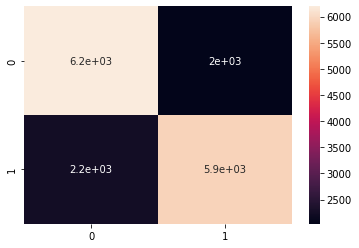

In [21]:
# confusion matrix heatmap
sns.heatmap(cm, annot=True)

In [22]:
# execution history
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

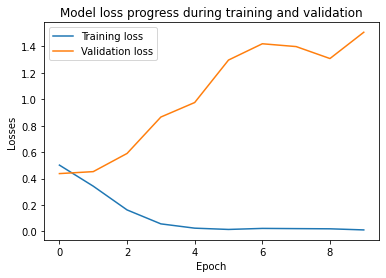

In [23]:
# chart - training and validation data versus loss progress
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

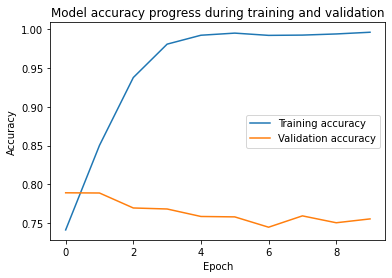

In [24]:
# chart - training and validation data versus accuracy progress
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

In [25]:
# predict - 1
text = 'Lula é o melhor presidente'
text = tokenizer.encode(text) # texto tokenizado

Dcnn(np.array([text]), training=False).numpy()

array([[0.9999517]], dtype=float32)

In [26]:
# predict - 2
text = 'Bolsonaro não é de nada'
text = tokenizer.encode(text) # texto tokenizado

Dcnn(np.array([text]), training=False).numpy()

array([[0.04521037]], dtype=float32)

## TWIITER - DADOS RECENTES - APLICAÇÃO REDES NEURAIS CONVOLUCIONAIS

In [27]:
import os
path = os.path.abspath(os.path.join('..', ''))


In [34]:
df_tweets = spark.read.parquet(path+"/datasource/trusted/tweets_preprocessing").toPandas()

In [35]:
df_tweets['tokenizers'] = [np.array([tokenizer.encode(token)]) for token in df_tweets['text_clean']]

In [37]:
df_tweets['sentiment_tax'] = [Dcnn(token, training=False)[0][0] for token in df_tweets['tokenizers']]

2022-08-07 12:29:16.994910: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2022-08-07 12:29:17.051306: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 3.23G (3468361728 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [39]:
df_tweets['sentiment'] = [1 if float(tensors) > 0.5 else 0 for tensors in df_tweets['sentiment_tax']]

In [40]:
df_tweets['sentiment'].value_counts()

1    70703
0    19262
Name: sentiment, dtype: int64

In [41]:
df_tweets.to_pickle('/home/daholive/Documents/twitter_ellection_brazil_v2/datasource/refined/tweets_redes_neurais_convolucionais/tweets_redes_neurais_convolucionais.pkl')

## ANALISE SERIE TEMPORAL

In [3]:
import pandas as pd

df_tweets = pd.read_pickle('/home/daholive/Documents/twitter_ellection_brazil_v2/datasource/refined/tweets_redes_neurais_convolucionais/tweets_redes_neurais_convolucionais.pkl')

2022-08-07 17:16:07.685418: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-07 17:16:08.632798: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-07 17:16:08.633358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-07 17:16:08.666237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 17:16:08.666362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2022-08-07 17:16:08.666382: I tensorflow/stream_executor/platform/def

In [4]:
df_tweets_resume = df_tweets[['query','created_at_tz','sentiment']]

In [41]:
df_tweets_analysis = df_tweets_resume.groupby(['query','created_at_tz','sentiment']).agg(
    {
        'sentiment':'count'
    }
).rename(columns={'sentiment':'count'}).reset_index().pivot_table(
    values='count',
    index=['query','created_at_tz'],
    columns=['sentiment'],
    aggfunc=np.sum
).rename(columns={0:'Negative',1:'Positive'}).reset_index()


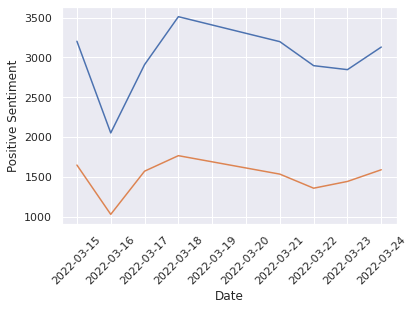

In [42]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

df_analysis = df_tweets_analysis[
    (df_tweets_analysis['query']=='lula') & ((df_tweets_analysis['created_at_tz']>datetime(2022,3,14).date()) & (df_tweets_analysis['created_at_tz']<datetime(2022,3,25).date()))
][['created_at_tz','Negative','Positive']]

sns.set()   

plt.ylabel('Positive Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)

plt.plot(df_analysis.created_at_tz, df_analysis['Positive'])
plt.plot(df_analysis.created_at_tz, df_analysis['Negative'])

In [1]:
import numpy as np

chris_gayle = np.array([32.44, 67.55, 61.08, 59.00, 21.77, 40.91, 22.70, 22.22, 40.88, 40.83])
rohit_sharma = np.array([28.85, 33.81, 30.92, 38.42, 30.00, 34.42, 44.45, 23.78, 23.83, 28.92])
ms_dhoni = np.array([31.88, 43.55, 29.83, 41.90, 74.20, 31.00, 40.57, 26.36, 75.83, 83.20])
virat_kohli = np.array([27.90, 46.41, 28.00, 45.28, 27.61, 45.90, 81.08, 30.80, 48.18, 33.14])

Text(0.04, 0.5, 'Average Scores in IPL Seasons')

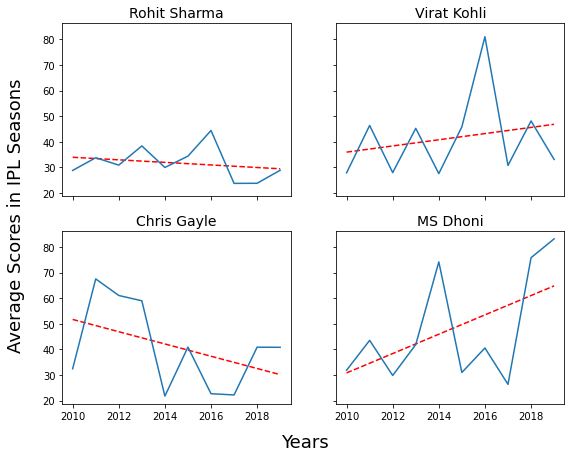

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#
# Number of years represented as Numpy Array
#
X = np.array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
fig, ax = plt.subplots(2, 2, figsize=(9, 7), sharex=True, sharey=True)

#
# Chris Gayle
#
z = np.polyfit(X, chris_gayle, 1)
p = np.poly1d(z)
ax[1, 0].plot(X,p(X),"r--")
ax[1, 0].plot(X, chris_gayle)
ax[1, 0].set_title('Chris Gayle', fontsize=14)

#
# Rohit Sharma
#
z = np.polyfit(X, rohit_sharma, 1)
p = np.poly1d(z)
ax[0, 0].plot(X,p(X),"r--")
ax[0, 0].plot(X, rohit_sharma )
ax[0, 0].set_title('Rohit Sharma', fontsize=14)

#
# MS Dhoni
#
z = np.polyfit(X, ms_dhoni, 1)
p = np.poly1d(z)
ax[1, 1].plot(X,p(X),"r--")
ax[1, 1].plot(X, ms_dhoni)
ax[1, 1].set_title('MS Dhoni', fontsize=14)

#
# Virat Kohli
#
z = np.polyfit(X, virat_kohli, 1)
p = np.poly1d(z)
ax[0, 1].plot(X,p(X),"r--")
ax[0, 1].plot(X, virat_kohli)
ax[0, 1].set_title('Virat Kohli', fontsize=14)

#
# Draw the plot
#
fig.text(0.5, 0.04, 'Years', ha='center', fontsize=18)
fig.text(0.04, 0.5, 'Average Scores in IPL Seasons', va='center', rotation='vertical', fontsize=18)

In [44]:
df_tweets_analysis = df_tweets_analysis[
    ((df_tweets_analysis['created_at_tz']>datetime(2022,3,14).date()) & (df_tweets_analysis['created_at_tz']<datetime(2022,3,25).date()))
][['query','created_at_tz','Negative','Positive']]

In [83]:
df_tweets_analysis.groupby('query').agg(
    {'Positive':'sum'}
)

sentiment,Positive
query,
aldo rebelo,120.0
alessandro vieira,288.0
andré janones,126.0
bolsonaro,28256.0
ciro gomes,4086.0
felipe d'ávila,28.0
joão doria,856.0
leonardo péricles,23.0
lula,23752.0


In [45]:
df_lula = df_tweets_analysis[
    (df_tweets_analysis['query']=='lula') 
][['created_at_tz','Negative','Positive']]

df_bolsonaro = df_tweets_analysis[
    (df_tweets_analysis['query']=='bolsonaro') 
][['created_at_tz','Negative','Positive']]

df_aldo_rebelo = df_tweets_analysis[
    (df_tweets_analysis['query']=='aldo rebelo') 
][['created_at_tz','Negative','Positive']]

df_alessandro_vieira = df_tweets_analysis[
    (df_tweets_analysis['query']=='alessandro vieira') 
][['created_at_tz','Negative','Positive']]

df_andre_janones = df_tweets_analysis[
    (df_tweets_analysis['query']=='andré janones') 
][['created_at_tz','Negative','Positive']]

df_ciro_gomes = df_tweets_analysis[
    (df_tweets_analysis['query']=='ciro gomes') 
][['created_at_tz','Negative','Positive']]

df_felipe_avila = df_tweets_analysis[
    (df_tweets_analysis['query']=="felipe d'ávila") 
][['created_at_tz','Negative','Positive']]

df_joao_doria = df_tweets_analysis[
    (df_tweets_analysis['query']=='joão doria') 
][['created_at_tz','Negative','Positive']]

df_leonardo_pericles = df_tweets_analysis[
    (df_tweets_analysis['query']=='leonardo péricles')
][['created_at_tz','Negative','Positive']]

df_rodrigo_pacheco = df_tweets_analysis[
    (df_tweets_analysis['query']=='rodrigo pacheco') 
][['created_at_tz','Negative','Positive']]

df_sergio_moro = df_tweets_analysis[
    (df_tweets_analysis['query']=='sergio moro') 
][['created_at_tz','Negative','Positive']]

df_simone_tebet = df_tweets_analysis[
    (df_tweets_analysis['query']=='simone tebet') 
][['created_at_tz','Negative','Positive']]

In [51]:
lula_pos = df_lula['Positive']
lula_neg = df_lula['Negative']

bolsonaro_pos = df_bolsonaro['Positive']
bolsonaro_neg = df_bolsonaro['Negative']

aldo_rebelo_pos = df_aldo_rebelo['Positive']
aldo_rebelo_neg = df_aldo_rebelo['Negative']

alessandro_vieira_pos = df_alessandro_vieira['Positive']
alessandro_vieira_neg = df_alessandro_vieira['Negative']

andre_janones_pos = df_andre_janones['Positive']
andre_janones_neg = df_andre_janones['Negative']

ciro_gomes_pos = df_ciro_gomes['Positive']
ciro_gomes_neg = df_ciro_gomes['Negative']

felipe_avila_pos = df_felipe_avila['Positive']
felipe_avila_neg = df_felipe_avila['Negative']

joao_doria_pos = df_joao_doria['Positive']
joao_doria_neg = df_joao_doria['Negative']

leonardo_pericles_pos = df_leonardo_pericles['Positive']
leonardo_pericles_neg = df_leonardo_pericles['Negative']

rodrigo_pacheco_pos = df_rodrigo_pacheco['Positive']
rodrigo_pacheco_neg = df_rodrigo_pacheco['Negative']

sergio_moro_pos = df_sergio_moro['Positive']
sergio_moro_neg = df_sergio_moro['Negative']

simone_tebet_pos = df_simone_tebet['Positive']
simone_tebet_neg = df_simone_tebet['Negative']

In [47]:
[x.day for x in df_tweets_analysis['created_at_tz'].unique()]

[15, 16, 17, 18, 21, 22, 23, 24]

Text(0.04, 0.5, 'Quantidade de Sentimentos')

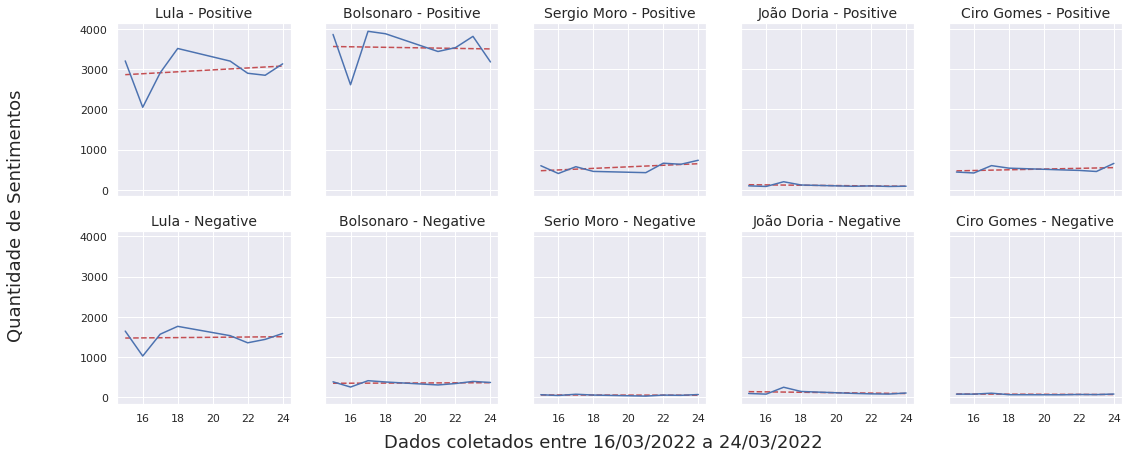

In [88]:
X = np.array([x.day for x in df_tweets_analysis['created_at_tz'].unique()])
fig, ax = plt.subplots(2, 5, figsize=(18, 7), sharex=True, sharey=True)

#
# lula
#
z = np.polyfit(X, lula_pos, 1)
p = np.poly1d(z)
ax[0, 0].plot(X,p(X),"r--")
ax[0, 0].plot(X, lula_pos )
ax[0, 0].set_title('Lula - Positive', fontsize=14)

# lula
#
z = np.polyfit(X, lula_neg, 1)
p = np.poly1d(z)
ax[1, 0].plot(X,p(X),"r--")
ax[1, 0].plot(X, lula_neg)
ax[1, 0].set_title('Lula - Negative', fontsize=14)


#
# Bolsonaro
#
z = np.polyfit(X, bolsonaro_pos, 1)
p = np.poly1d(z)
ax[0, 1].plot(X,p(X),"r--")
ax[0, 1].plot(X, bolsonaro_pos )
ax[0, 1].set_title('Bolsonaro - Positive', fontsize=14)

# Bolsonaro
#
z = np.polyfit(X, bolsonaro_neg, 1)
p = np.poly1d(z)
ax[1, 1].plot(X,p(X),"r--")
ax[1, 1].plot(X, bolsonaro_neg)
ax[1, 1].set_title('Bolsonaro - Negative', fontsize=14)


#
# Sergio Moro
#
z = np.polyfit(X, sergio_moro_pos, 1)
p = np.poly1d(z)
ax[0, 2].plot(X,p(X),"r--")
ax[0, 2].plot(X, sergio_moro_pos )
ax[0, 2].set_title('Sergio Moro - Positive', fontsize=14)

# Sergio Moro
#
z = np.polyfit(X, sergio_moro_neg, 1)
p = np.poly1d(z)
ax[1, 2].plot(X,p(X),"r--")
ax[1, 2].plot(X, sergio_moro_neg)
ax[1, 2].set_title('Serio Moro - Negative', fontsize=14)

#
# João Doria
#
z = np.polyfit(X, joao_doria_pos, 1)
p = np.poly1d(z)
ax[0, 3].plot(X,p(X),"r--")
ax[0, 3].plot(X, joao_doria_pos )
ax[0, 3].set_title('João Doria - Positive', fontsize=14)

# João Doria
#
z = np.polyfit(X, joao_doria_neg, 1)
p = np.poly1d(z)
ax[1, 3].plot(X,p(X),"r--")
ax[1, 3].plot(X, joao_doria_neg)
ax[1, 3].set_title('João Doria - Negative', fontsize=14)

#
# Ciro Gomes
#
z = np.polyfit(X, ciro_gomes_pos, 1)
p = np.poly1d(z)
ax[0, 4].plot(X,p(X),"r--")
ax[0, 4].plot(X, ciro_gomes_pos )
ax[0, 4].set_title('Ciro Gomes - Positive', fontsize=14)

# Ciro Gomes
#
z = np.polyfit(X, ciro_gomes_neg, 1)
p = np.poly1d(z)
ax[1, 4].plot(X,p(X),"r--")
ax[1, 4].plot(X, ciro_gomes_neg)
ax[1, 4].set_title('Ciro Gomes - Negative', fontsize=14)


fig.text(0.5, 0.04, 'Dados coletados entre 16/03/2022 a 24/03/2022', ha='center', fontsize=18)
fig.text(0.04, 0.5, 'Quantidade de Sentimentos', va='center', rotation='vertical', fontsize=18)